# Berlin Temperature Spiral

The goal of this project was to create an animated spiral of Montreal's variation in temperature from 1872 to 2019.

**Background:** [Ed Hawkins](http://www.met.reading.ac.uk/~ed/home/index.php), a climate scientist, unveiled [an animated visualization](http://www.climate-lab-book.ac.uk/spirals/) in 2017 which captivated the world. This visualization showed the deviations of the global average temperature from 1850 to 2017. It was reshared millions of times over Twitter and Facebook and a version of it was even shown at the opening ceremony for the Rio Olympics.

This animation was created with the help of [an article on Dataquest.io](https://www.dataquest.io/blog/climate-temperature-spirals-python/) written by Srini Kadamati.

Historical weather data was retrieved from [Kaggle dataset](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data)

### Reading in Data

In [375]:
import pandas as pd
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

# Reading and transforming the file
cities = pd.read_csv('/content/GlobalLandTemperaturesByMajorCity.csv')
df = cities.loc[cities['City'] == 'Berlin', ['dt','AverageTemperature']]
df.columns = ['Date','AverageTemperature']
df['Date'] = pd.to_datetime(df['Date'])
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df.reset_index(drop=True, inplace=True)
df.set_index('Date', inplace=True)

#I'm going to consider the temperature just from 1900 until the end of 2012
df = df.loc['1800':'2013-01-01']
df = df.asfreq('M', method='bfill')

In [376]:
df["year"].value_counts(ascending=True).head()

2013     1
1800    11
1802    12
1937    12
1938    12
Name: year, dtype: int64

In [377]:
# Find and drop incomplete years with less or more than 12 monaths

df_counts = df.groupby(["year"])["year"].count()
df_counts = df_counts.to_frame()
df_counts["count"] = df_counts["year"]
df_counts = df_counts.drop(['year'], axis=1)
df_counts = df_counts.reset_index()
drop_year_list = df_counts["year"].loc[df_counts['count'] != 12].tolist()

for year in drop_year_list:
  df = df.drop(df[df["year"]==year].index)
df["year"].value_counts(ascending=True).head()

1801    12
1936    12
1937    12
1938    12
1939    12
Name: year, dtype: int64

In [378]:
min_year = df["year"].min()
max_year = df["year"].max()

### Preparing Data for Polar Plotting

Each spiral that will be plotted contains temperature values for a single year. This means that we need to subset the data by year and use the following coordinates:

- r: temperature value for a given month, adjusted to contain **no negative values**. Matplotlib supports plotting negative values, but we want -0.1 to be closer to the center than 0.1 (which isn’t the default matplotlib behavior). We also want to leave some space around the origin of the plot for displaying the year as text.

- theta: 12 equally spaced angle values that span from 0.5*pi to -1.5*pi.

We can start plotting the data for the year 1862, then scale up to all years.

To adjust the data to contain no negative temperature values, we need to first calculate the minimum temperature value:

In [379]:
# Calculating minimum value

df["mean_temp"] = df["AverageTemperature"]
df = df
min_temp = math.ceil(abs(df['mean_temp'].min()))


In [380]:
# Subracting baseline mean monthly temperature from each corresponding monthly temperatures

length_temp_data = len(pd.unique(df["year"]))

for i in range(1,13): # months 1 inclusive to 13 exclusive
    df.loc[df['month'] == i, 'mean_temp'] -= df[df['month'] == i]['mean_temp'].iloc[:length_temp_data].mean() # iloc 29 selects years 1872 

We can add min temperature to all temperature values, so they can be positive and still leave some space for text to be displayed around the origin.

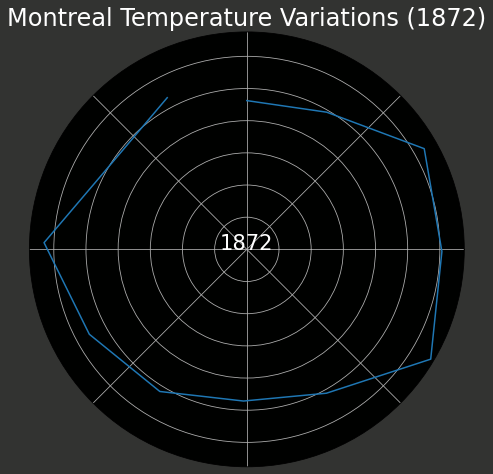

In [381]:
# Subsetting data for 1862
temp_1872 = df[df['year'] == 1862]

# To use polar system, we need to set the projection parameter to "polar" when creating it
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111, projection = 'polar')

# Setting coordinates
r = temp_1872['mean_temp'] + min_temp # plotting temperature (y axis)
theta = np.linspace(0.5*np.pi, (-1.5+2/13)*np.pi, 12) # 12 equally spaced values

# Hiding tick labels 
ax1.axes.get_yaxis().set_ticklabels([])
ax1.axes.get_xaxis().set_ticklabels([])

# Setting foreground colour
fig.set_facecolor("#323331") # gray

# Setting background colour
ax1.set_facecolor('#000100') # black

# Setting title
ax1.set_title("Montreal Temperature Variations (1872)", color = 'white', fontdict = {'fontsize': 24})

# Adding text in center
ax1.text(0, 0, "1872", color = 'white', size = 21, ha = 'center')

# Displaying plot
ax1.plot(theta, r)

### Plotting Remaining Years

In [382]:
# Calculating max value in temperature data
max_temp = df['mean_temp'].max()

### Adding Temperature Rings and Month Labels

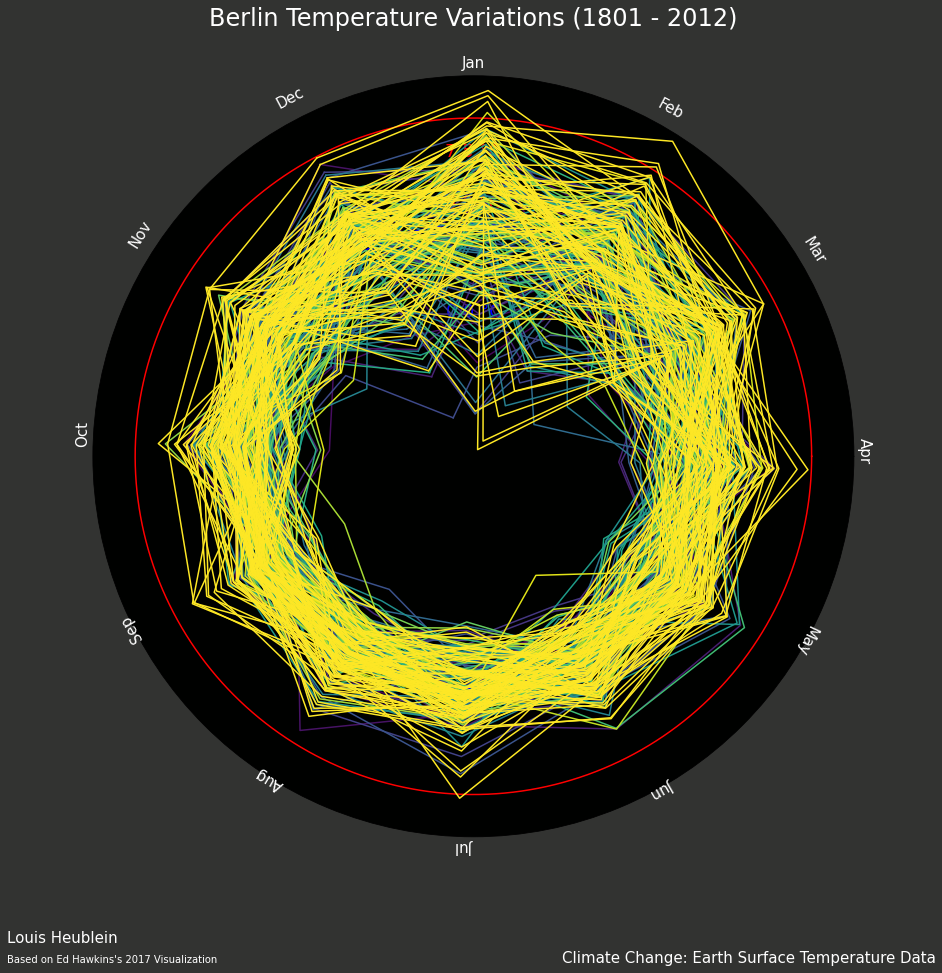

In [383]:
# Plotting temperature variations
fig = plt.figure(figsize=(14,14))
ax1 = plt.subplot(111, projection='polar')

# Hiding tick labels
# ax1.axes.get_yaxis().set_ticklabels([])
# ax1.axes.get_xaxis().set_ticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])

# Setting title
ax1.set_title(f"Berlin Temperature Variations ({min_year} - {max_year})", color='white', fontdict={'fontsize': 24}, pad=50)

# Setting foreground colour
fig.set_facecolor("#323331")

# Setting background color
ax1.set_facecolor('#000100')

# Setting limit to polar plot by adding padding to max temperature value
ax1.set_ylim(0, 18)

# Setting x coordinates
theta = np.linspace((0.5+2/13)*np.pi, (-1.5+2/13)*np.pi, 13) # 12 equally spaced values

# Getting list of unique values in year column
years = df['year'].unique()

# Designing temperature rings
full_circle_thetas = np.linspace(0, 2*np.pi, 1000)
blue_line_one_radii = [0 + min_temp]*1000 # ring for 0 degrees, adding min_temp for negative adjustment
red_line_two_radii = [5 + min_temp]*1000 # ring for 5 degrees, adding min_temp for negative adjustment
red_line_three_radii = [7.5 + min_temp]*1000 # ring for 10 degrees, adding min_temp for negative adjustment

# Plotting temperature rings
ax1.plot(full_circle_thetas, blue_line_one_radii, c='blue')
ax1.plot(full_circle_thetas, red_line_two_radii, c='red')
ax1.plot(full_circle_thetas, red_line_three_radii, c='red')

# Adding ring text
ax1.text(np.pi/2, 6.6, "0.0 °C", color="blue", ha='center', fontdict={'fontsize': 18}, bbox=dict(facecolor='#000100', edgecolor='#000100'), zorder = 2)
ax1.text(np.pi/2, 11.7, "5.0 °C", color="red", ha='center', fontdict={'fontsize': 18}, bbox=dict(facecolor='#000100', edgecolor='#000100'), zorder = 2)
ax1.text(np.pi/2, 14.2, "7.5 °C", color="red", ha='center', fontdict={'fontsize': 18}, bbox=dict(facecolor='#000100', edgecolor='#000100'), zorder = 2)

# add creator information
fig.text(0.6,0,"Climate Change: Earth Surface Temperature Data",color="white",fontsize=15)
fig.text(0.05,0.02,"Louis Heublein",color="white",fontsize=15)
fig.text(0.05,0,"Based on Ed Hawkins's 2017 Visualization",color="white",fontsize=10)

# Adding labels for months
months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"] # listing months
months_angles = np.linspace(0.5*np.pi, (-1.5+2/13)*np.pi, 12) # setting angles for labels
months_position = [18.4, 18.5, 18.5, 18.5, 18.3, 18.5, 18.65, 18.5, 18.4, 18.5, 18.6, 18.6] # setting heights for labels
months_rotation = [0, -28, -58, -90, -115, -150, 180, 150, 120, 90, 58, 28] # setting rotation of labels
for i, month in enumerate(months): # adding labels to each angle
  ax1.text(months_angles[i], months_position[i], month, color = "white", fontsize = 15, ha = "center", rotation = months_rotation[i])

# Plotting all temperatures
for index, year in enumerate(years):
    if year == min_year:
        # Setting y coordinates
        r = df.loc[df['year'] == year, 'mean_temp'] + min_temp # plotting temperatures for min_year, 12 months
    else:
        # Setting y coordinates
        r = df.loc[(df['year'] == year) | ((df['year'] == year-1) & (df['month'] == 12)), 'mean_temp'] + min_temp # plotting temperatures for all following years, connecting with month 12 of previous year each time to complete circle
        # ax1.text(0,0, str(year), color='white', size=30, ha='center') # ignoring text to avoid superimposition
        ax1.grid(False) # getting rid of grid
        ax1.plot(theta, r, color = plt.cm.viridis(index*2), zorder = 10) # multiply by 2 to get to yellow colour, zorder lines to go over text

### Creating GIF Animation

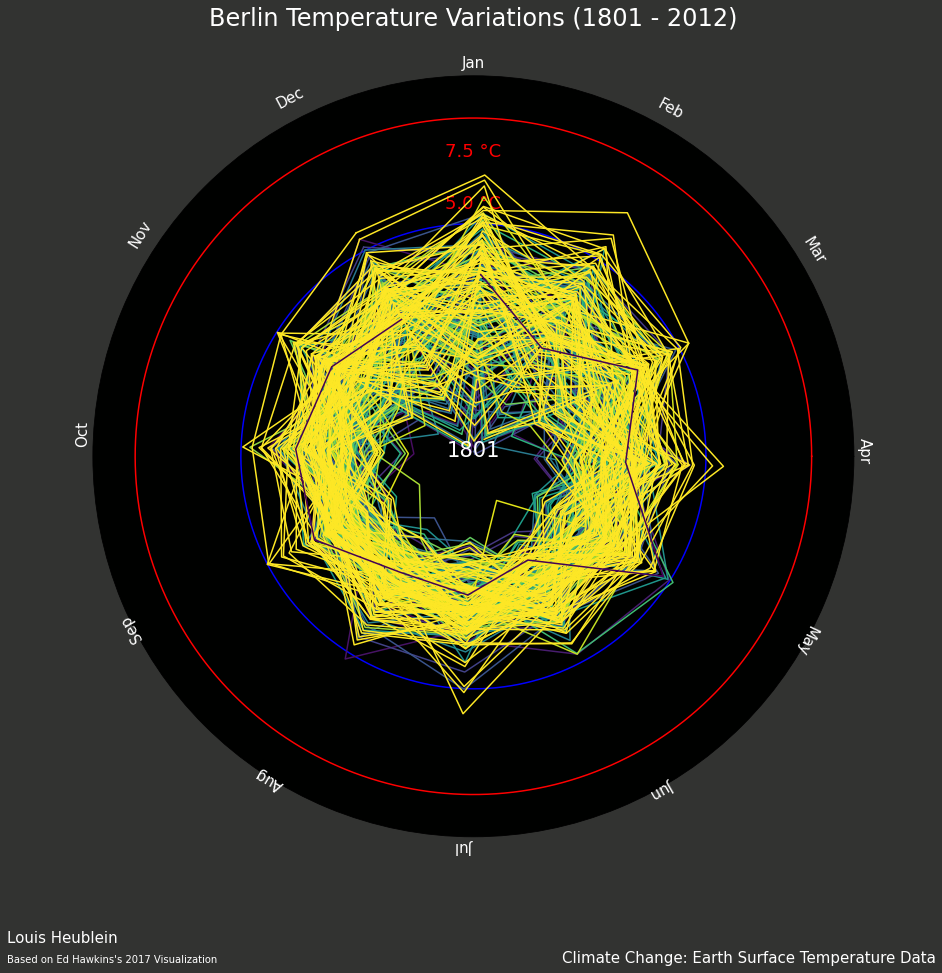

In [384]:
# Importing function to write out animation as GIF file
from matplotlib.animation import FuncAnimation

#Plotting temperature variations
fig = plt.figure(figsize=(14,14))
ax1 = plt.subplot(111, projection='polar')

# Hiding tick labels
# ax1.axes.get_yaxis().set_ticklabels([])
# ax1.axes.get_xaxis().set_ticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])

# Setting title
ax1.set_title(f"Berlin Temperature Variations ({min_year} - {max_year})", color='white', fontdict={'fontsize': 24}, pad=50)

## Setting foreground colour
fig.set_facecolor("#323331")

# Setting background color
ax1.set_facecolor('#000100')

# Setting limit to polar plot by adding padding to max temperature value
ax1.set_ylim(0, 18)

# Setting x coordinates
theta = np.linspace((0.5+2/13)*np.pi, (-1.5+2/13)*np.pi, 13) # 12 equally spaced values

# Adding null value to month 12 year 1871 in order to simplify complete circles creation
df = pd.concat([pd.DataFrame({'year': [min_year-1], 'month': [12], 'mean_temp': [np.nan]}), df], ignore_index = True)

# Getting list of unique values in year column
years = df.loc[df['year'] > min_year-1, 'year'].unique()

# Designing temperature rings
full_circle_thetas = np.linspace(0, 2*np.pi, 1000)
blue_line_one_radii = [0 + min_temp]*1000 # ring for 0 degrees, adding min_temp for negative adjustment
red_line_two_radii = [5 + min_temp]*1000 # ring for 5 degrees, adding min_temp for negative adjustment
red_line_three_radii = [7.5 + min_temp]*1000 # ring for 10 degrees, adding min_temp for negative adjustment

# Plotting temperature rings
ax1.plot(full_circle_thetas, blue_line_one_radii, c='blue')
ax1.plot(full_circle_thetas, red_line_two_radii, c='red')
ax1.plot(full_circle_thetas, red_line_three_radii, c='red')

# Adding ring text
ax1.text(np.pi/2, 6.6, "0.0 °C", color="blue", ha='center', fontdict={'fontsize': 18}, bbox=dict(facecolor='#000100', edgecolor='#000100'), zorder = 2)
ax1.text(np.pi/2, 11.7, "5.0 °C", color="red", ha='center', fontdict={'fontsize': 18}, bbox=dict(facecolor='#000100', edgecolor='#000100'), zorder = 2)
ax1.text(np.pi/2, 14.2, "7.5 °C", color="red", ha='center', fontdict={'fontsize': 18}, bbox=dict(facecolor='#000100', edgecolor='#000100'), zorder = 2)

# add creator information
fig.text(0.6,0,"Climate Change: Earth Surface Temperature Data",color="white",fontsize=15)
fig.text(0.05,0.02,"Louis Heublein",color="white",fontsize=15)
fig.text(0.05,0,"Based on Ed Hawkins's 2017 Visualization",color="white",fontsize=10)

# Adding labels for months
months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"] # listing months
months_angles = np.linspace(0.5*np.pi, (-1.5+2/13)*np.pi, 12) # setting angles for labels
months_position = [18.4, 18.5, 18.5, 18.5, 18.3, 18.5, 18.65, 18.5, 18.4, 18.5, 18.6, 18.6] # setting heights for labels
months_rotation = [0, -28, -58, -90, -115, -150, 180, 150, 120, 90, 58, 28] # setting rotation of labels
for i, month in enumerate(months): # adding labels to each angle
  ax1.text(months_angles[i], months_position[i], month, color = "white", fontsize = 15, ha = "center", rotation = months_rotation[i])

# Creating function to plot all temperatures
def update(i):
    # Remove the last year text at the center
    for txt in ax1.texts:
      if(txt.get_position() == (0,0)):
        txt.set_visible(False)
    year = years[i] # enumerating years
    r = df.loc[(df['year'] == year) | ((df['year'] == year-1) & (df['month'] == 12)), 'mean_temp'] + 7 # plotting temperatures for all following years, connecting with month 12 of previous year each time to complete circle
    ax1.text(0,0, str(year), color = 'white', size = 21, ha = 'center', zorder = 20) # showing year on top of everything
    ax1.grid(False) # getting rid of grid
    ax1.plot(theta, r, color = plt.cm.viridis(i*2), zorder = 10) # multiply by 2 to get to yellow colour, zorder lines to go over text    
    return ax1

anim = FuncAnimation(fig, update, frames = len(years), interval = 160, repeat = False)

# Saving animation
anim.save('berlin_temperature_spiral.gif', dpi=120, writer='pillow', savefig_kwargs={'facecolor': '#323331'})